# Bibliotecas

In [280]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from scipy.stats import randint, uniform, mannwhitneyu, shapiro

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

import shap

from joblib import dump

# Carregando Dados

In [282]:
data = pd.read_csv('assets/Hove_et_al_2020.csv')

In [69]:
data.columns

Index(['Unnamed: 0', 'WBC', 'NEU', 'LYM', 'MON', 'BAS', 'EOS', 'pid', 'BMI',
       'Age', 'NumPartos', 'RepStatus', 'AgeCat', 'crp', 'Population',
       'lym_pct', 'neu_pct', 'eos_pct', 'mon_pct', 'bas_pct', 'Repeats',
       'REF'],
      dtype='object')

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2330 non-null   int64  
 1   WBC         2244 non-null   float64
 2   NEU         2244 non-null   float64
 3   LYM         2244 non-null   float64
 4   MON         2244 non-null   float64
 5   BAS         2244 non-null   float64
 6   EOS         2244 non-null   float64
 7   pid         2330 non-null   object 
 8   BMI         2330 non-null   float64
 9   Age         2330 non-null   int64  
 10  NumPartos   2330 non-null   int64  
 11  RepStatus   2330 non-null   object 
 12  AgeCat      2330 non-null   int64  
 13  crp         846 non-null    float64
 14  Population  2330 non-null   object 
 15  lym_pct     2244 non-null   float64
 16  neu_pct     2244 non-null   float64
 17  eos_pct     2244 non-null   float64
 18  mon_pct     2244 non-null   float64
 19  bas_pct     2244 non-null  

In [71]:
data.Population.value_counts()

Population
NHANES    1395
THLHP      935
Name: count, dtype: int64

In [72]:
data.loc[data.Population == "THLHP"].RepStatus.value_counts()

RepStatus
Cycling    679
T2          94
T3          91
T1          71
Name: count, dtype: int64

In [73]:
data.loc[data.Population == "NHANES"].RepStatus.value_counts()

RepStatus
Cycling    1118
T2          113
T3          111
T1           53
Name: count, dtype: int64

In [75]:
columns = ['WBC', 'NEU', 'LYM', 'MON', 'BAS', 'EOS',  'BMI', "crp", 'Age', 'NumPartos', 'RepStatus', 'Population']

In [198]:
df = data[columns]#.dropna()

df_THLHP = df[df.Population == 'THLHP'].reset_index(drop=True)

df_NHANES = df[df.Population == 'NHANES'].reset_index(drop=True)


In [34]:
df_NHANES.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   WBC         1327 non-null   float64
 1   NEU         1327 non-null   float64
 2   LYM         1327 non-null   float64
 3   MON         1327 non-null   float64
 4   BAS         1327 non-null   float64
 5   EOS         1327 non-null   float64
 6   BMI         1395 non-null   float64
 7   crp         752 non-null    float64
 8   Age         1395 non-null   int64  
 9   NumPartos   1395 non-null   int64  
 10  RepStatus   1395 non-null   object 
 11  Population  1395 non-null   object 
dtypes: float64(8), int64(2), object(2)
memory usage: 130.9+ KB


In [35]:
df_THLHP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   WBC         917 non-null    float64
 1   NEU         917 non-null    float64
 2   LYM         917 non-null    float64
 3   MON         917 non-null    float64
 4   BAS         917 non-null    float64
 5   EOS         917 non-null    float64
 6   BMI         935 non-null    float64
 7   crp         94 non-null     float64
 8   Age         935 non-null    int64  
 9   NumPartos   935 non-null    int64  
 10  RepStatus   935 non-null    object 
 11  Population  935 non-null    object 
dtypes: float64(8), int64(2), object(2)
memory usage: 87.8+ KB


# Análise dos dados

## Outliers

In [199]:
# Lista das colunas que você quer analisar
variaveis = ['WBC', 'NEU', 'LYM', 'MON', 'BAS', 'EOS']

# Dicionário para armazenar contagem de outliers
outliers_info = []

for var in variaveis:
    serie = data[var].dropna()
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    outliers = serie[(serie < lim_inf) | (serie > lim_sup)]
    
    outliers_info.append({
        'Variável': var,
        'Q1': round(Q1, 2),
        'Q3': round(Q3, 2),
        'IQR': round(IQR, 2),
        'Limite Inferior': round(lim_inf, 2),
        'Limite Superior': round(lim_sup, 2),
        'N_outliers': len(outliers),
        'Porcentagem_outliers': round(100 * len(outliers) / len(serie), 2)
    })

# Cria DataFrame com os resultados
tabela_outliers = pd.DataFrame(outliers_info)

# Exibe tabela
tabela_outliers

,Variável,Q1,Q3,IQR,Limite Inferior,Limite Superior,N_outliers,Porcentagem_outliers
0,WBC,6800.0,10100.00,3300.00,1850.00,15050.00,43,1.92
1,NEU,3600.0,6020.25,2420.25,-30.38,9650.62,48,2.14
2,LYM,1867.5,2900.00,1032.50,318.75,4448.75,58,2.58
3,MON,0.0,600.00,600.00,-900.00,1500.00,1,0.04
4,BAS,0.0,100.00,100.00,-150.00,250.00,9,0.40
5,EOS,100.0,1089.00,989.00,-1383.50,2572.50,149,6.64


In [283]:
# Condição combinada
cond = (
    (data.WBC < 22000) &
    (data.NEU < 15000) &
    (data.LYM < 8000) &
    (data.MON < 1250) &
    (data.BAS < 400) &
    (data.EOS < 5000)
)

# Dados filtrados e removidos
dados = data.loc[cond]
dados_removidos = data.loc[~cond]

In [201]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2224 entries, 0 to 2311
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2224 non-null   int64  
 1   WBC         2224 non-null   float64
 2   NEU         2224 non-null   float64
 3   LYM         2224 non-null   float64
 4   MON         2224 non-null   float64
 5   BAS         2224 non-null   float64
 6   EOS         2224 non-null   float64
 7   pid         2224 non-null   object 
 8   BMI         2224 non-null   float64
 9   Age         2224 non-null   int64  
 10  NumPartos   2224 non-null   int64  
 11  RepStatus   2224 non-null   object 
 12  AgeCat      2224 non-null   int64  
 13  crp         751 non-null    float64
 14  Population  2224 non-null   object 
 15  lym_pct     2224 non-null   float64
 16  neu_pct     2224 non-null   float64
 17  eos_pct     2224 non-null   float64
 18  mon_pct     2224 non-null   float64
 19  bas_pct     2224 non-null   floa

In [202]:
dados_removidos

,Unnamed: 0,WBC,NEU,LYM,MON,BAS,EOS,pid,BMI,Age,...,AgeCat,crp,Population,lym_pct,neu_pct,eos_pct,mon_pct,bas_pct,Repeats,REF
401,402,11000.0,7300.0,2900.0,300.0,400.0,200.0,23414,28.930000,30,...,24,2.100000,NHANES,26.363636,66.363636,1.818182,2.0,3.0,1,0
583,584,18200.0,15500.0,1700.0,800.0,100.0,200.0,39060,24.400000,24,...,24,NaN,NHANES,9.340659,85.164835,1.098901,4.0,0.0,1,0
699,700,7800.0,6100.0,1100.0,200.0,400.0,100.0,26930,36.520000,24,...,24,9.500000,NHANES,14.102564,78.205128,1.282051,2.0,5.0,1,0
830,831,12200.0,7200.0,4100.0,400.0,400.0,200.0,25019,45.660000,38,...,32,4.200000,NHANES,33.606557,59.016393,1.639344,3.0,3.0,1,0
871,872,28700.0,16600.0,8000.0,1700.0,2100.0,300.0,25249,55.640000,35,...,32,NaN,NHANES,27.874564,57.839721,1.045296,5.0,7.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,2326,NaN,NaN,NaN,NaN,NaN,NaN,3.33111E+11,23.652075,44,...,42,3.375520,THLHP,NaN,NaN,NaN,NaN,NaN,1,0
2326,2327,NaN,NaN,NaN,NaN,NaN,NaN,3.3311E+11,21.585099,43,...,42,7.861467,THLHP,NaN,NaN,NaN,NaN,NaN,2,1
2327,2328,NaN,NaN,NaN,NaN,NaN,NaN,3.33243E+11,23.699013,44,...,42,1.061760,THLHP,NaN,NaN,NaN,NaN,NaN,1,0
2328,2329,NaN,NaN,NaN,NaN,NaN,NaN,3.33408E+13,21.943323,44,...,42,0.311040,THLHP,NaN,NaN,NaN,NaN,NaN,1,0


In [203]:
# Conta quantas linhas têm pelo menos um NaN
num_nan = dados_removidos.isna().any(axis=1).sum()
print(f"Número de linhas removidas com pelo menos um NaN: {num_nan}")

# Subconjunto das linhas removidas que têm pelo menos um NaN
removidos_com_nan = dados_removidos[dados_removidos.isna().any(axis=1)]

# Contagem de NaNs por coluna nesse subconjunto
na_por_coluna = removidos_com_nan.isna().sum()
print(na_por_coluna)

Número de linhas removidas com pelo menos um NaN: 97
Unnamed: 0     0
WBC           86
NEU           86
LYM           86
MON           86
BAS           86
EOS           86
pid            0
BMI            0
Age            0
NumPartos      0
RepStatus      0
AgeCat         0
crp           11
Population     0
lym_pct       86
neu_pct       86
eos_pct       86
mon_pct       86
bas_pct       86
Repeats        0
REF            0
dtype: int64


In [295]:
dados.Population.value_counts()

Population
NHANES    1317
THLHP      907
Name: count, dtype: int64

In [293]:
dados.loc[dados.Population == 'THLHP'].RepStatus.value_counts()

RepStatus
Cycling    653
T2          93
T3          91
T1          70
Name: count, dtype: int64

In [294]:
dados.loc[dados.Population == 'NHANES'].RepStatus.value_counts()

RepStatus
Cycling    1055
T3          106
T2          104
T1           52
Name: count, dtype: int64

## Distribuição das varaiveis

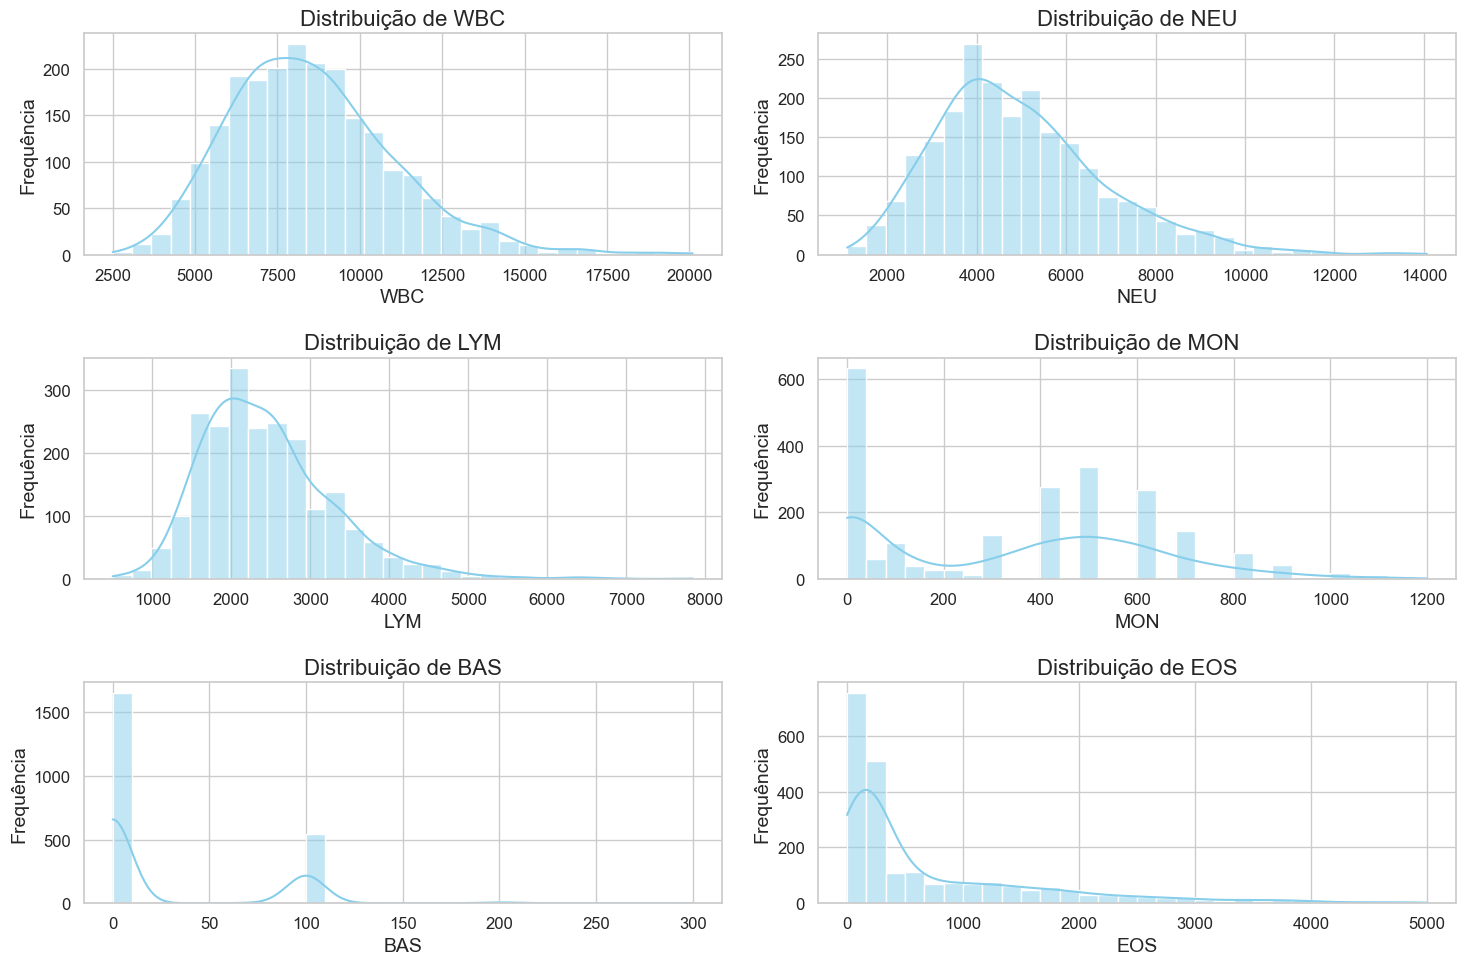

In [284]:

variaveis = ['WBC', 'NEU', 'LYM', 'MON', 'BAS', 'EOS']

# Configurações gerais
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)  # Aumenta escala de fonte

# Gera um histograma para cada variável
for i, var in enumerate(variaveis, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=dados, x=var, kde=True, bins=30, color='skyblue')
    plt.title(f'Distribuição de {var}', fontsize=16)
    plt.xlabel(var, fontsize=14)
    plt.ylabel('Frequência', fontsize=14)
    plt.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

#### Distribuição das varaiveis por população e gravidez

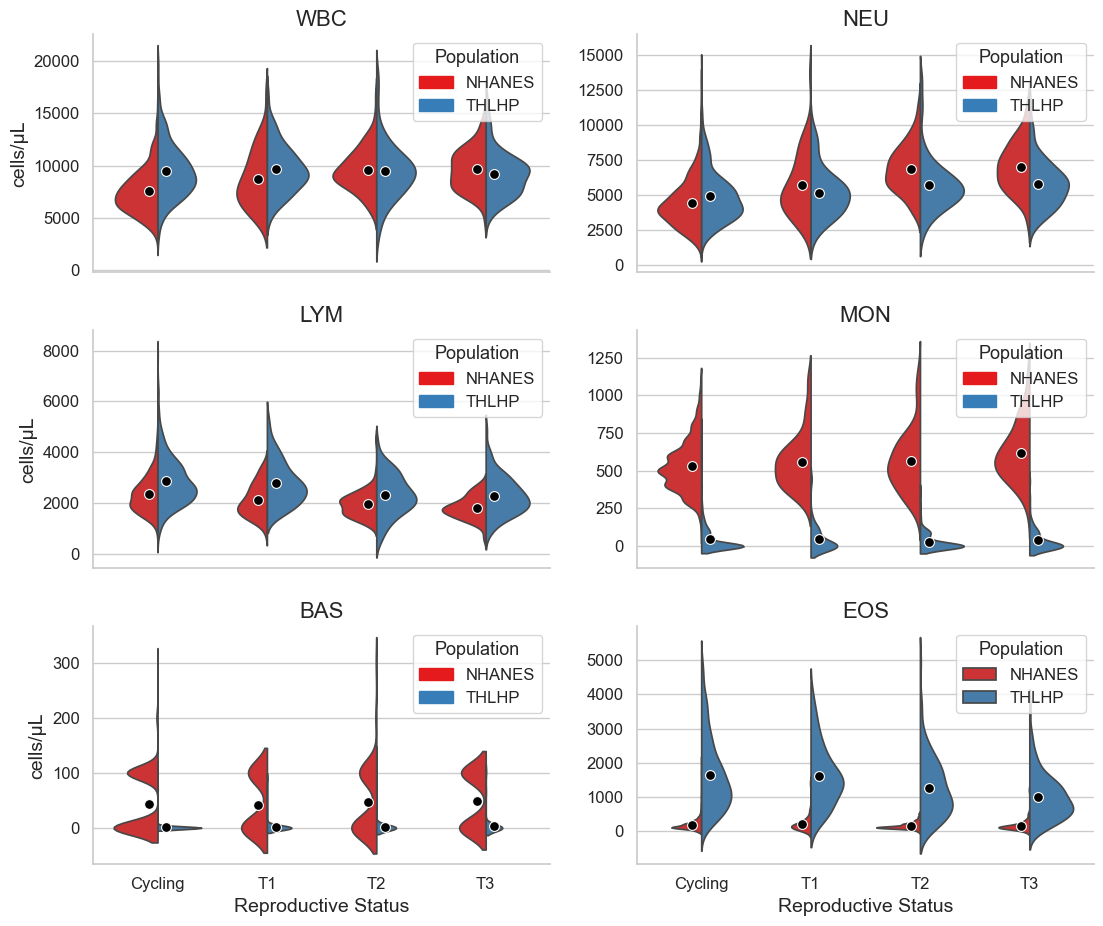

In [250]:
# Tipos celulares
cell_types = ['WBC', 'NEU', 'LYM', 'MON', 'BAS', 'EOS']

# Derrete o DataFrame
dados_long = dados.melt(
    id_vars=['RepStatus', 'Population'],
    value_vars=cell_types,
    var_name='Cell_Type',
    value_name='Cell_Count'
)

# Ordem (se necessário)
repstatus_order = ['Cycling', 'T1', 'T2', 'T3']
population_order = ['NHANES', 'THLHP']

# Garanta que as colunas categóricas tenham a ordem definida
dados_long['RepStatus'] = pd.Categorical(dados_long['RepStatus'], categories=repstatus_order, ordered=True)
dados_long['Population'] = pd.Categorical(dados_long['Population'], categories=population_order, ordered=True)
dados_long['Cell_Type'] = pd.Categorical(dados_long['Cell_Type'], categories=cell_types, ordered=True)

# Aumenta todas as fontes proporcionalmente
sns.set_context("notebook", font_scale=1.5)

# Criação do gráfico
g = sns.catplot(
    data=dados_long,
    x='RepStatus',
    y='Cell_Count',
    hue='Population',
    col='Cell_Type',
    kind='violin',
    split=True,
    inner=None,
    palette='Set1',
    height=3.2,
    aspect=1.5,
    col_wrap=2,
    order=repstatus_order,
    hue_order=population_order,
    sharey=False
)

# Remove legenda global
if g._legend:
    g._legend.remove()

# Adiciona médias e legendas individuais com fontes aumentadas
for i, ax in enumerate(g.axes.flat):
    cell_type = g.col_names[i]
    subset = dados_long[dados_long['Cell_Type'] == cell_type]

    handles, labels = ax.get_legend_handles_labels()

    for j, status in enumerate(repstatus_order):
        for pop in population_order:
            pop_data = subset[(subset['RepStatus'] == status) & (subset['Population'] == pop)]
            mean_val = pop_data['Cell_Count'].mean()
            offset = -0.08 if pop == 'NHANES' else 0.08
            ax.scatter(j + offset, mean_val, color='black', s=50, marker='o', zorder=10,
                       edgecolor='white', linewidth=0.8)

    # Título com fonte maior
    ax.set_title(cell_type, fontsize=16)
    ax.tick_params(axis='both', labelsize=12)

    # Adiciona legenda, se necessário
    if not handles:
        palette = sns.color_palette('Set1', n_colors=len(population_order))
        handles = [Patch(color=palette[k], label=pop) for k, pop in enumerate(population_order)]
        labels = population_order

    ax.legend(handles=handles, labels=labels, title='Population', loc='upper right',
              bbox_to_anchor=(1, 1), fontsize=12, title_fontsize=13)

# Rótulos dos eixos com fonte maior
g.set_axis_labels("Reproductive Status", "cells/μL", fontsize=14)
g.set_titles(col_template="{col_name}", size=16)

plt.tight_layout()
plt.show()

## CRP

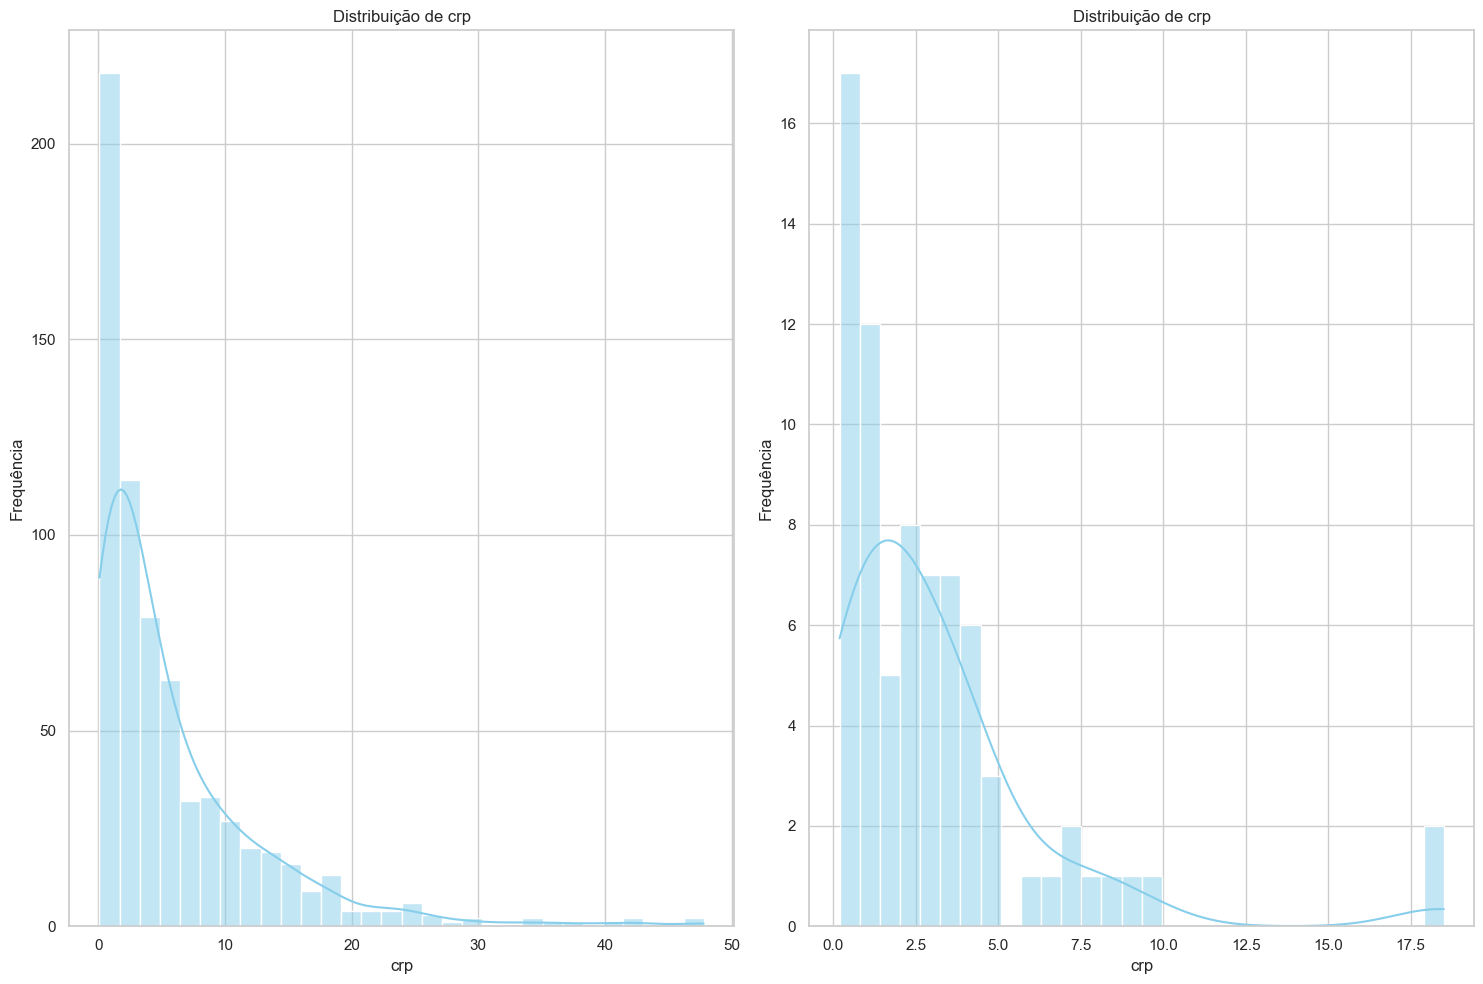

In [88]:

# Configurações gerais do gráfico
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

plt.subplot(1, 2, 1)
sns.histplot(data=dados.loc[dados.Population == 'NHANES'], x='crp', kde=True, bins=30, color='skyblue')
plt.title(f'Distribuição de crp')
plt.xlabel("crp")
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
sns.histplot(data=dados.loc[dados.Population == 'THLHP'], x='crp', kde=True, bins=30, color='skyblue')
plt.title(f'Distribuição de crp')
plt.xlabel("crp")
plt.ylabel('Frequência')


plt.tight_layout()
plt.show()

## TEstes estatisticos

### Normalidade Por Population + RepStatus

In [ ]:

# Lista das colunas de células
cell_types = ['WBC', 'NEU', 'LYM', 'MON', 'BAS', 'EOS']

# Criar um dicionário para guardar resultados
results = []

# Agrupa por Population e RepStatus
grouped = dados.groupby(['Population', 'RepStatus'])

for (pop, rep), group in grouped:
    for cell in cell_types:
        data = group[cell].dropna()  # remove NaNs para o teste
        if len(data) >= 3:  # Shapiro precisa de pelo menos 3 dados
            stat, p_value = shapiro(data)
            normal = p_value > 0.05  # H0: dados seguem distribuição normal
            results.append({
                'Population': pop,
                'RepStatus': rep,
                'Cell_Type': cell,
                'Shapiro_stat': stat,
                'p_value': p_value,
                'Normal_Distribution': normal
            })
        else:
            results.append({
                'Population': pop,
                'RepStatus': rep,
                'Cell_Type': cell,
                'Shapiro_stat': None,
                'p_value': None,
                'Normal_Distribution': None
            })

# Converter para DataFrame para melhor visualização
df_results = pd.DataFrame(results)

df_results_true = df_results[df_results['Normal_Distribution'] == True]

df_results_true

,Population,RepStatus,Cell_Type,Shapiro_stat,p_value,Normal_Distribution
6,NHANES,T1,WBC,0.955696,0.050993,True
8,NHANES,T1,LYM,0.956083,0.052986,True
12,NHANES,T2,WBC,0.977885,0.079075,True
13,NHANES,T2,NEU,0.984413,0.263163,True
18,NHANES,T3,WBC,0.986298,0.350885,True
19,NHANES,T3,NEU,0.989396,0.574326,True
20,NHANES,T3,LYM,0.982339,0.171614,True
30,THLHP,T1,WBC,0.973677,0.146994,True
38,THLHP,T2,LYM,0.992956,0.908438,True
44,THLHP,T3,LYM,0.972818,0.053606,True


### Diferencia das médias

#### Medias diferentes

In [ ]:


# Variáveis que você quer comparar
variaveis = ['WBC', 'NEU', 'LYM', 'MON', 'BAS', 'EOS']
repstatus_list = ['Cycling', 'T1', 'T2', 'T3']

# Inicializa tabela resultado
resultados = []

for status in repstatus_list:
    linha = {'RepStatus': status}
    for var in variaveis:
        # Subconjuntos
        grupo_nhanes = dados[(dados['RepStatus'] == status) & (dados['Population'] == 'NHANES')][var].dropna()
        grupo_thlhp = dados[(dados['RepStatus'] == status) & (dados['Population'] == 'THLHP')][var].dropna()
        
        # Verifica se tem dados suficientes
        if len(grupo_nhanes) > 0 and len(grupo_thlhp) > 0:
            stat, pval = mannwhitneyu(grupo_nhanes, grupo_thlhp, alternative='two-sided')
        else:
            pval = None  # ou float('nan') se preferir
        
        linha[var] = pval
    resultados.append(linha)

# Cria DataFrame com os resultados
tabela_resultados = pd.DataFrame(resultados)

tabela_resultados_rounded = tabela_resultados.copy()
cols_numericas = tabela_resultados_rounded.select_dtypes(include='number').columns
tabela_resultados_rounded[cols_numericas] = tabela_resultados_rounded[cols_numericas].round(4)

# Exibe a tabela
tabela_resultados_rounded


,RepStatus,WBC,NEU,LYM,MON,BAS,EOS
0,Cycling,0.0000,0.0000,0.0000,0.0,0.0,0.0
1,T1,0.0243,0.2874,0.0000,0.0,0.0,0.0
2,T2,0.5630,0.0000,0.0002,0.0,0.0,0.0
3,T3,0.0522,0.0000,0.0000,0.0,0.0,0.0


#### Média nhanes menor

In [208]:
import pandas as pd

# Variáveis que você quer comparar
variaveis = ['WBC', 'NEU', 'LYM', 'MON', 'BAS', 'EOS']
repstatus_list = ['Cycling', 'T1', 'T2', 'T3']

# Inicializa tabela resultado
resultados = []

for status in repstatus_list:
    linha = {'RepStatus': status}
    for var in variaveis:
        # Subconjuntos
        grupo_nhanes = dados[(dados['RepStatus'] == status) & (dados['Population'] == 'NHANES')][var].dropna()
        grupo_thlhp = dados[(dados['RepStatus'] == status) & (dados['Population'] == 'THLHP')][var].dropna()
        
        # Verifica se tem dados suficientes
        if len(grupo_nhanes) > 0 and len(grupo_thlhp) > 0:
            stat, pval = mannwhitneyu(grupo_nhanes, grupo_thlhp, alternative='less')
        else:
            pval = None  # ou float('nan') se preferir
        
        linha[var] = pval
    resultados.append(linha)

# Cria DataFrame com os resultados
tabela_resultados = pd.DataFrame(resultados)

tabela_resultados_rounded = tabela_resultados.copy()
cols_numericas = tabela_resultados_rounded.select_dtypes(include='number').columns
tabela_resultados_rounded[cols_numericas] = tabela_resultados_rounded[cols_numericas].round(4)

# Exibe a tabela
tabela_resultados_rounded


,RepStatus,WBC,NEU,LYM,MON,BAS,EOS
0,Cycling,0.0000,0.0000,0.0000,1.0,1.0,0.0
1,T1,0.0121,0.8575,0.0000,1.0,1.0,0.0
2,T2,0.7193,1.0000,0.0001,1.0,1.0,0.0
3,T3,0.9741,1.0000,0.0000,1.0,1.0,0.0


#### Média nhanes maior

In [209]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Variáveis que você quer comparar
variaveis = ['WBC', 'NEU', 'LYM', 'MON', 'BAS', 'EOS']
repstatus_list = ['Cycling', 'T1', 'T2', 'T3']

# Inicializa tabela resultado
resultados = []

for status in repstatus_list:
    linha = {'RepStatus': status}
    for var in variaveis:
        # Subconjuntos
        grupo_nhanes = dados[(dados['RepStatus'] == status) & (dados['Population'] == 'NHANES')][var].dropna()
        grupo_thlhp = dados[(dados['RepStatus'] == status) & (dados['Population'] == 'THLHP')][var].dropna()
        
        # Verifica se tem dados suficientes
        if len(grupo_nhanes) > 0 and len(grupo_thlhp) > 0:
            stat, pval = mannwhitneyu(grupo_nhanes, grupo_thlhp, alternative='greater')
        else:
            pval = None  # ou float('nan') se preferir
        
        linha[var] = pval
    resultados.append(linha)

# Cria DataFrame com os resultados
tabela_resultados = pd.DataFrame(resultados)

tabela_resultados_rounded = tabela_resultados.copy()
cols_numericas = tabela_resultados_rounded.select_dtypes(include='number').columns
tabela_resultados_rounded[cols_numericas] = tabela_resultados_rounded[cols_numericas].round(4)

# Exibe a tabela
tabela_resultados_rounded

,RepStatus,WBC,NEU,LYM,MON,BAS,EOS
0,Cycling,1.0000,1.0000,1.0000,0.0,0.0,1.0
1,T1,0.9880,0.1437,1.0000,0.0,0.0,1.0
2,T2,0.2815,0.0000,0.9999,0.0,0.0,1.0
3,T3,0.0261,0.0000,1.0000,0.0,0.0,1.0


## Correlações

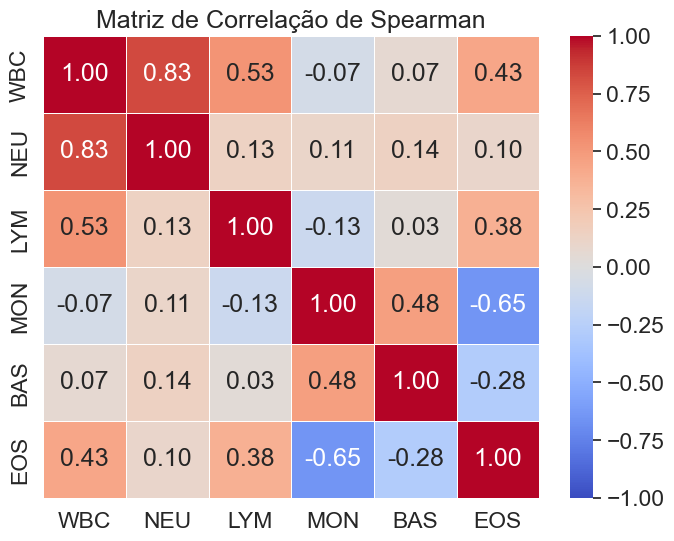

In [290]:
variaveis_selecionadas = ['WBC', 'NEU', 'LYM', 'MON', 'BAS', 'EOS']
df_selecionado = dados[variaveis_selecionadas]

# Calcule a matriz de correlação de Spearman
matriz_correlacao_spearman = df_selecionado.corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(
    matriz_correlacao_spearman,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar=True,
    vmin=-1, vmax=1  # força a escala da barra de cores entre -1 e 1
)
plt.title('Matriz de Correlação de Spearman')
plt.show()


# Apredizado de Máquina

## Preparando dados

In [285]:
df_ml = dados.copy()

mapa_repstatus = {'Cycling': 0, 'T1': 1, 'T2': 2, 'T3': 3}
df_ml['RepStatus_cat'] = df_ml['RepStatus'].map(mapa_repstatus)


df_ml['RepStatus_bin'] = df_ml['RepStatus'].apply(lambda x: 'Pregnant' if x in ['T1', 'T2', 'T3'] else 'NotPregnant')
# Converter 'RepStatus_bin' para binária (1 = grávida, 0 = não grávida)
df_ml['RepStatus_bin'] = (df_ml['RepStatus_bin'] == 'Pregnant').astype(int)

df_ml['Population_bin'] = (df_ml['Population'] == 'THLHP').astype(int)




## Regressão

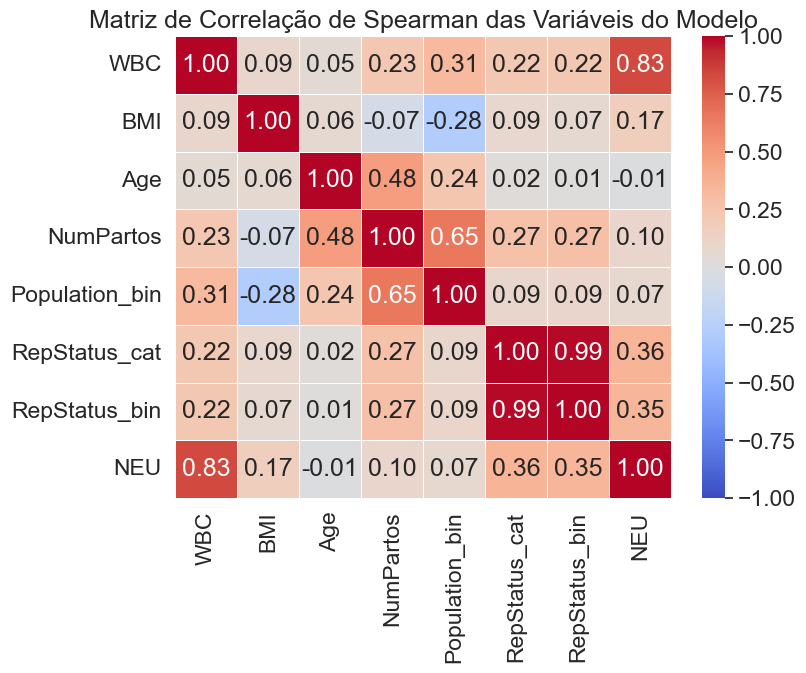

In [292]:
features = ['WBC', 'BMI', 'Age', 'NumPartos', 'Population_bin', "RepStatus_cat", 'RepStatus_bin']
target = 'NEU'

matriz_correlacao_modelo = df_ml[features + ['NEU']].corr(method='spearman') 

plt.figure(figsize=(8, 6))
sns.heatmap(
    matriz_correlacao_modelo,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar=True,
    vmin=-1, vmax=1  # força a escala da barra de cores entre -1 e 1
)
plt.title('Matriz de Correlação de Spearman das Variáveis do Modelo')
plt.show()

In [287]:
features = ['WBC', 'BMI', 'Age', 'NumPartos', 'Population_bin', "RepStatus_cat", 'RepStatus_bin']
target = 'NEU'

# Remover linhas com valores faltantes nas colunas selecionadas
df_model = df_ml[features + [target]].dropna()

# Separar X e y
X = df_model[features]
y = df_model[target]

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Ajusta e transforma com base no treino
X_test = scaler.transform(X_test)   

In [268]:
modelos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "SVR": SVR(kernel='rbf', C=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Cálculo del R² ajustado
    n = X_test.shape[0]  # Número de observaciones
    p = X_test.shape[1]  # Número de predictores
    r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    
    print(f"{nome:<20} | MAE: {mae:.3f} | MSE: {mse:.3f} | R²: {r2:.3f} | R²-ajustado: {r2_ajustado:.3f}")

LinearRegression     | MAE: 641.500 | MSE: 690218.579 | R²: 0.787 | R²-ajustado: 0.784
Ridge                | MAE: 641.455 | MSE: 690130.326 | R²: 0.787 | R²-ajustado: 0.784
Lasso                | MAE: 641.505 | MSE: 690189.280 | R²: 0.787 | R²-ajustado: 0.784
SVR                  | MAE: 1342.617 | MSE: 3047631.082 | R²: 0.059 | R²-ajustado: 0.044
RandomForest         | MAE: 649.504 | MSE: 694481.110 | R²: 0.786 | R²-ajustado: 0.782
GradientBoosting     | MAE: 616.030 | MSE: 641115.475 | R²: 0.802 | R²-ajustado: 0.799


In [288]:
modelo = GradientBoostingRegressor(n_estimators=100, random_state=42)

modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
    
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
    
# Cálculo del R² ajustado
n = X_test.shape[0]  # Número de observaciones
p = X_test.shape[1]  # Número de predictores
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    
print(f"{nome:<20} | MAE: {mae:.3f} | MSE: {mse:.3f} | R²: {r2:.3f} | R²-ajustado: {r2_ajustado:.3f}")

GradientBoosting     | MAE: 616.030 | MSE: 641115.475 | R²: 0.802 | R²-ajustado: 0.799


In [289]:
# Salvar o modelo
dump(modelo, 'modelo_gradient_boosting.pkl')

# Salvar o scaler
dump(scaler, 'scaler.pkl')

['scaler.pkl']

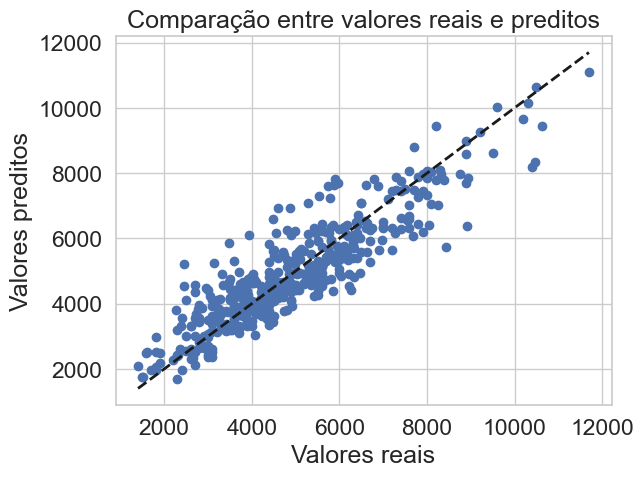

In [270]:
plt.scatter(y_test, y_pred)
plt.xlabel("Valores reais")
plt.ylabel("Valores preditos")
plt.title("Comparação entre valores reais e preditos")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

In [271]:
mae_perc = (mae / y_test.mean()) * 100
print(f'MAE: {mae:.3f}')
print(f"Média NEU_teste: {y_test.mean():.3f}")
print(f"Erro absoluto médio relativo: {mae_perc:.2f}%")

MAE: 616.030
Média NEU_teste: 4905.397
Erro absoluto médio relativo: 12.56%


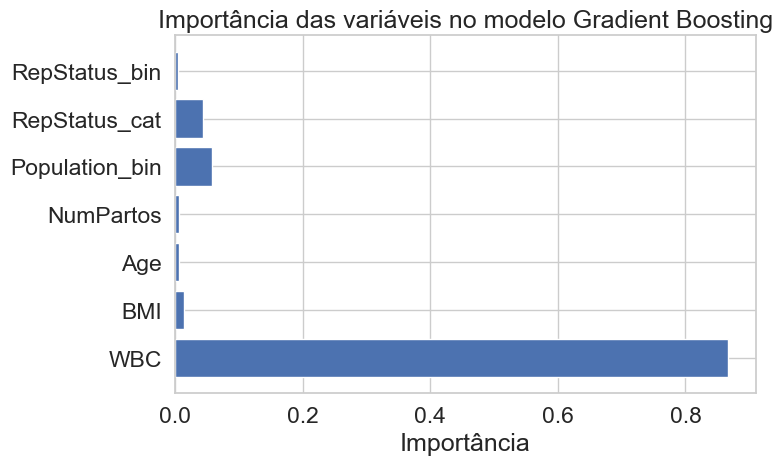

In [272]:
importances = modelo.feature_importances_
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else features

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Importância")
plt.title("Importância das variáveis no modelo Gradient Boosting")
plt.tight_layout()
plt.show()

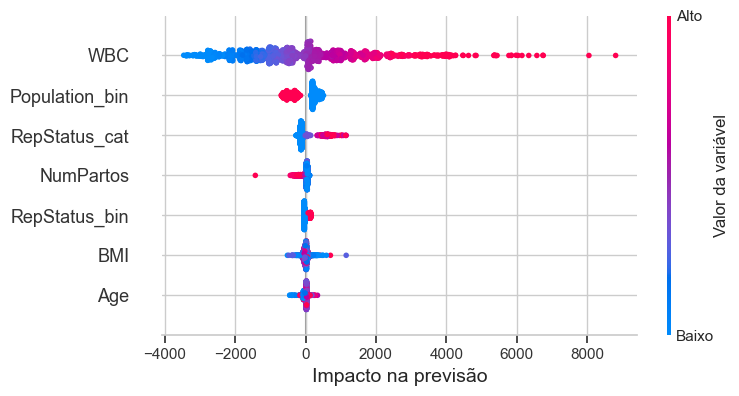

In [278]:
# Lista com os nomes corretos das colunas usadas no modelo
colunas_modelo = ['WBC', 'BMI', 'Age', 'NumPartos', 'Population_bin', "RepStatus_cat", 'RepStatus_bin']

X_train_df = pd.DataFrame(X_train, columns=colunas_modelo)

# Cria o explicador SHAP
explainer = shap.Explainer(modelo, X_train_df)

# Calcula os valores SHAP
shap_values = explainer(X_train_df)

# Cria o gráfico
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values, X_train_df, show=False)

# Personalização do gráfico
plt.xlabel("Impacto na previsão", fontsize=14)
fig = plt.gcf()
cbar = fig.axes[-1]
cbar.set_ylabel("Valor da variável", fontsize=12)
cbar.set_yticks(cbar.get_yticks())
cbar.set_yticklabels(["Baixo", "Alto"])
plt.tight_layout()
plt.show()

In [274]:
modelo.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [275]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

# Criar o modelo base
gbr = GradientBoostingRegressor(random_state=42)

# GridSearch com validação cruzada 5-fold
grid_search = GridSearchCV(estimator=gbr,
                           param_grid=param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=1)

# Ajustar aos dados (sem escalonamento, pois GB não precisa)
grid_search.fit(X_train, y_train)

# Melhor modelo
best_model = grid_search.best_estimator_
print("Melhores parâmetros:", grid_search.best_params_)

y_pred = best_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Melhores parâmetros: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
MAE: 621.8800391660895
MSE: 648404.8531376843
R²: 0.7998943704471562


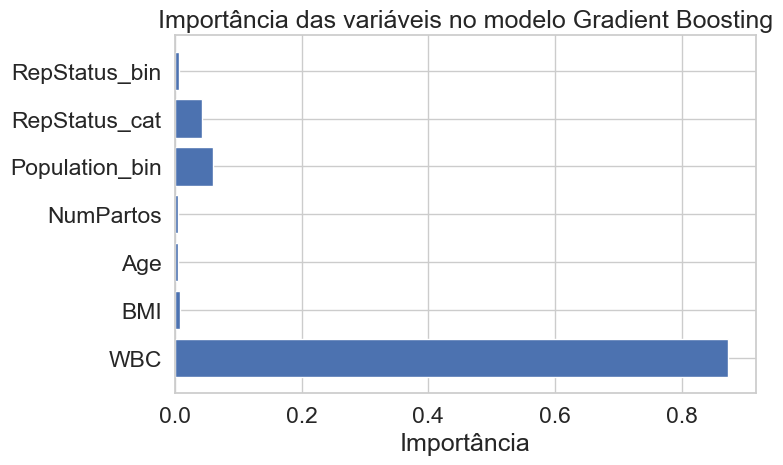

In [276]:
importances = best_model.feature_importances_
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else features

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Importância")
plt.title("Importância das variáveis no modelo Gradient Boosting")
plt.tight_layout()
plt.show()

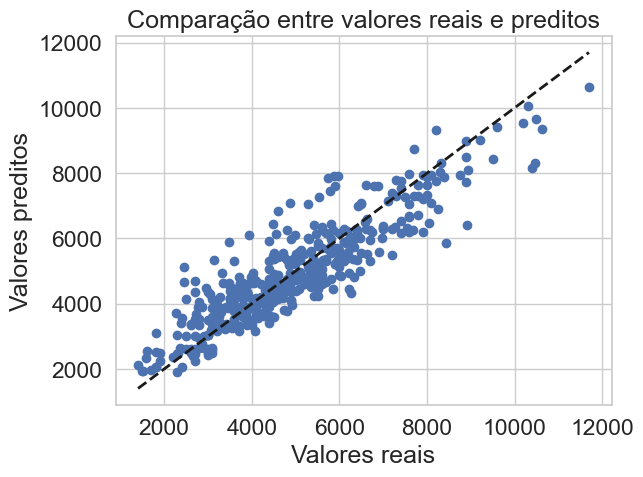

In [277]:
plt.scatter(y_test, y_pred)
plt.xlabel("Valores reais")
plt.ylabel("Valores preditos")
plt.title("Comparação entre valores reais e preditos")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

## Classificação

In [225]:
# Exemplo de features que você pode usar
features = ['WBC', 'NEU', 'BMI', 'Age', 'NumPartos', 'RepStatus_bin', "RepStatus_cat" ]
target = 'Population_bin'

df_model = df_ml[features + [target]].dropna()

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [226]:
modelos = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='rbf', probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"{nome:<20} | Accuracy: {acc:.3f}")

LogisticRegression   | Accuracy: 0.870
SVM                  | Accuracy: 0.899
RandomForest         | Accuracy: 0.901
GradientBoosting     | Accuracy: 0.915


              precision    recall  f1-score   support

           0       0.92      0.94      0.93       264
           1       0.91      0.87      0.89       181

    accuracy                           0.91       445
   macro avg       0.91      0.91      0.91       445
weighted avg       0.91      0.91      0.91       445



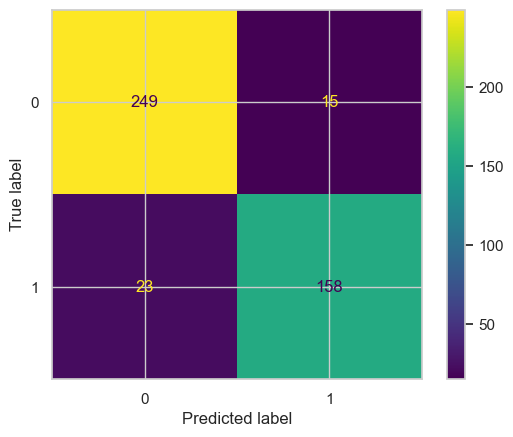

In [227]:
best_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

## Agrupamento 

In [ ]:
colunas_agrupamento = ['WBC', 'NEU', 'LYM', 'MON', 'BAS', 'EOS',  'BMI',
       'Age', 'NumPartos', 'RepStatus', 'Population',
       'lym_pct', 'neu_pct', 'eos_pct', 'mon_pct', 'bas_pct']

dados_agrupamento = dados[colunas_agrupamento].copy()

mapa_repstatus = {'Cycling': 0, 'T1': 1, 'T2': 2, 'T3': 3}
dados_agrupamento['RepStatus_cat'] = dados_agrupamento['RepStatus'].map(mapa_repstatus)


dados_agrupamento['RepStatus_bin'] = dados_agrupamento['RepStatus'].apply(lambda x: 'Pregnant' if x in ['T1', 'T2', 'T3'] else 'NotPregnant')
# Converter 'RepStatus_bin' para binária (1 = grávida, 0 = não grávida)
dados_agrupamento['RepStatus_bin'] = (dados_agrupamento['RepStatus_bin'] == 'Pregnant').astype(int)

# dados_agrupamento['Population_bin'] = (dados_agrupamento['Population'] == 'THLHP').astype(int)

dados_agrupamento.drop(columns=['RepStatus'], inplace=True)



# Remover 'Population' (para não vazar informação no clustering)
X = dados_agrupamento.drop(columns=['Population'])

# Padronizar os dados (K-Means é sensível à escala!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adicionar os clusters ao DataFrame original
dados_agrupamento['Cluster'] = clusters

# Tabela de contingência para comparar Cluster x Population
cross_tab = pd.crosstab(dados_agrupamento['Cluster'], dados_agrupamento['Population'])
print(cross_tab)

Population  NHANES  THLHP
Cluster                  
0             1314     39
1                3    868


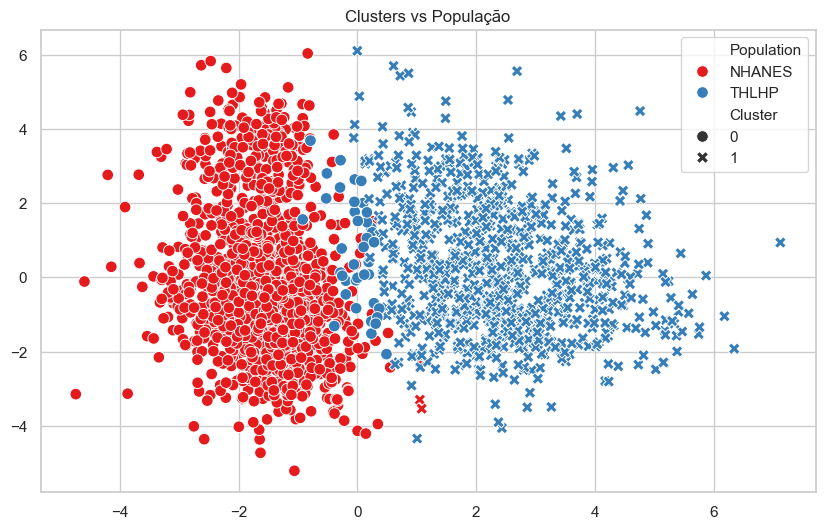

In [246]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], 
                hue=dados_agrupamento['Population'], 
                style=dados_agrupamento['Cluster'],
                palette='Set1', s=70)
plt.title("Clusters vs População")
plt.legend()
plt.show()

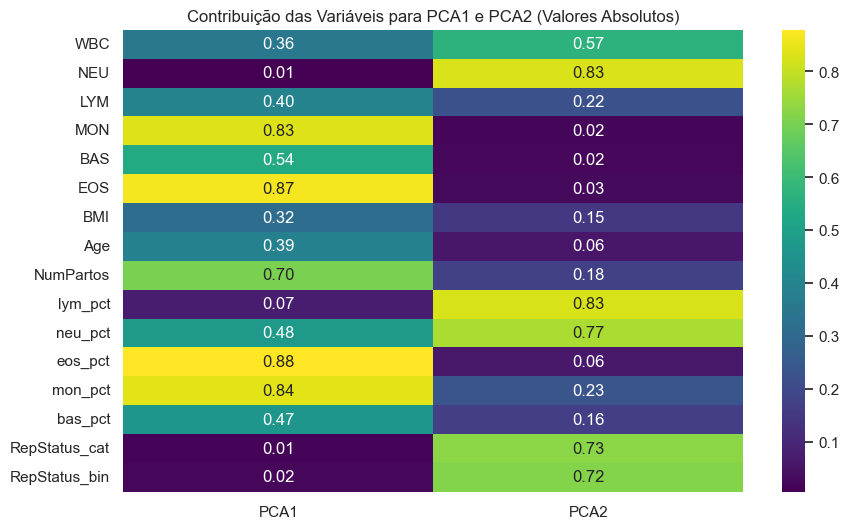

In [244]:
# Supondo que X_scaled já está padronizado (como no código anterior)
pca = PCA(n_components=2)  # Manter 2 componentes para visualização
X_pca = pca.fit_transform(X_scaled)

# Obter os loadings (pesos das variáveis em cada PCA)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Criar um DataFrame com os loadings
loadings_df = pd.DataFrame(loadings, 
                          columns=['PCA1', 'PCA2'], 
                          index=X.columns)

plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df.abs(), annot=True, cmap='viridis', fmt=".2f")
plt.title("Contribuição das Variáveis para PCA1 e PCA2 (Valores Absolutos)")
plt.show()